In [1]:
import matplotlib
import pickle

from pathlib import Path
import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pyfaidx import Fasta
from meth5 import MetH5File

from nanoepitools.plotting.general_plotting import PlotArchiver, plot_2d_density
from nanoepitools.reference_cpgs import ReferenceCpGs

from benchmark_pycometh.simulation.nanopolish_simulator import OmicsSimlaLoader
from benchmark_pycometh.utils import unions
from benchmark_pycometh.config import module_config
from benchmark_pycometh.diffmet.diffmet_results import Results

In [6]:
pa = PlotArchiver("simulation", headless=False, config={"plot_archive_dir": "/home/r933r/snajder/nanoepitools_plots/benchmark"})
reference_cpgs = ReferenceCpGs(module_config.reference)
m5_path = {s: module_config.meth5_template_file.format(sample=s) for s in ["HG003", "HG004"]}
results_cache_file = "/home/r933r/data/projects/nanopore/pycometh_benchmark/pycometh/samplecomp/all_results_cache.pkl"
load_from_cache=False

In [7]:
def get_result_file(caller, segmentation=None, test=None, ihw=False, segments_per_window=None, window_size=None):
    basedir = Path("/home/r933r/data/projects/nanopore/pycometh_benchmark/")

    if caller == "methcp":
        return basedir.joinpath("bs/mock_bsseq_from_nanopore/parents_mockbsseq_segments_methcp_diffmet.tsv")

    ihw = f"ihw_{'yes' if ihw else 'no'}"
    if segmentation == "pycometh":
        basedir = basedir.joinpath("pycometh","samplecomp", "cpg", "diffmet")
        fn = f"diffmet_{window_size}_{segments_per_window}_hyp_{test}_{ihw}.tsv"
    else:
        basedir = basedir.joinpath("pycometh", f"samplecomp_{segmentation}", "cpg", "diffmet")
        fn = f"diffmet_hyp_{test}_{ihw}.tsv"

    return basedir.joinpath(fn)

def get_all_result_files():
    yield {"key":"MethCP", "file":get_result_file("methcp", "methcp"), "caller": "methcp"}
    for label, segmentation in  ("PycoMeth", "pycometh"), ("PycoMeth (MethylKit)", "methylkit"), ("PycoMeth (MethCP)", "methcp"):
        for ihw in True, False:
            for test_label, test in ("BS Diff", "bs_diff"), ("LLR-Diff", "llr_diff"), ("Fisher-E","count_dependency"):
                name = f"{label} {test_label}{' (IHW)' if ihw else ''}"
                if segmentation == "pycometh":
                    yield {"key": name + " coarse", "caller": "pycometh", "file": get_result_file("pycometh", segmentation, test, ihw, 12, 300)}
                    yield {"key": name, "caller": "pycometh", "file": get_result_file("pycometh", segmentation, test, ihw, 20, 300)}
                else:
                    yield {"key": name, "caller": "pycometh", "file": get_result_file("pycometh", segmentation, test, ihw)}


In [8]:
if load_from_cache:
    with open(results_cache_file, "rb") as f:
        results = pickle.load(f)
else:
    results = Results(reference_cpgs, m5_path, include_chroms={"20"}, read_group_key=None, samples=["HG003", "HG004"])

In [9]:
for res_config in get_all_result_files():
    if res_config["key"] not in results.segments:
        results.load_segments(**res_config)

Loading MethCP
Filtering chromosomes
Annotating CpGs for MethCP
Loading diffmet for MethCP (2262 segments)
Finished loading MethCP (2184 segments)
Loading PycoMeth BS Diff (IHW) coarse
Filtering chromosomes
Annotating CpGs for PycoMeth BS Diff (IHW) coarse
Loading diffmet for PycoMeth BS Diff (IHW) coarse (5899 segments)
Finished loading PycoMeth BS Diff (IHW) coarse (5898 segments)
Loading PycoMeth BS Diff (IHW)
Filtering chromosomes
Annotating CpGs for PycoMeth BS Diff (IHW)
Loading diffmet for PycoMeth BS Diff (IHW) (7254 segments)
Finished loading PycoMeth BS Diff (IHW) (7254 segments)
Loading PycoMeth LLR-Diff (IHW) coarse
Filtering chromosomes
Annotating CpGs for PycoMeth LLR-Diff (IHW) coarse
Loading diffmet for PycoMeth LLR-Diff (IHW) coarse (8593 segments)
Finished loading PycoMeth LLR-Diff (IHW) coarse (8593 segments)
Loading PycoMeth LLR-Diff (IHW)
Filtering chromosomes
Annotating CpGs for PycoMeth LLR-Diff (IHW)
Loading diffmet for PycoMeth LLR-Diff (IHW) (10484 segments)
F

In [10]:
del results.reference_cpgs.ref
with open(results_cache_file, "bw") as f:
    pickle.dump(results, f)

In [11]:
results.colors = {}
for key in results.segments:
    if key == "MethCP":
        results.colors[key] = "#88498F"
    elif "(MethCP)" in key:
        results.colors[key] = "#C492B1"
    elif "(MethylKit)" in key:
        results.colors[key] = "#49C6E5"
    elif "coarser" in key:
        results.colors[key] = "#C96300"
    elif "coarse" in key:
        results.colors[key] = "#ED7400"
    else:
        results.colors[key] = "#D58936"

results.patterns = {}
for key in results.segments:
    if "LLR-Diff" in key:
        if "IHW" in key:
            results.patterns[key] = "O"
        else:
            results.patterns[key] = "/"
    elif "BS Diff" in key:
        if "IHW" in key:
            results.patterns[key] = "."
        else:
            results.patterns[key] = "\\"
    elif "Fisher-E" in key:
        if "IHW" in key:
            results.patterns[key] = "o"
        else:
            results.patterns[key] = "-"
    else:
        results.patterns[key] = ""

In [32]:
def get_dmrs(key, pval_thres = 0.05, min_diff = 0.1, additional_index=None):
    segments = results.segments[key]
    if additional_index is not None:
        segments = segments.loc[additional_index]
    segments = segments.loc[segments["adj_pvalue"] < pval_thres]
    segments = segments.loc[segments["diffmet"].map(lambda x: abs(x) > min_diff)]
    return segments

def get_num_dmr_cpgs(key, **kwargs):
    dmrs = get_dmrs(key, **kwargs)
    return len(unions(dmrs["CpGs"]))

def plot_bar_diffmetcolored(x, key, diffmet_thresholds = [0.1, 0.2, 0.3, 0.4, 0.6, 0.8, 1.0], cmap="jet"):
    cmap = matplotlib.cm.get_cmap(cmap)
    last_thres = diffmet_thresholds[0]
    diffmet_thresholds = diffmet_thresholds[1:]
    left = 0
    segments = results.segments[key]
    for thres in diffmet_thresholds:
        color = cmap((thres+last_thres)/2)
        idx = segments["diffmet"].map(lambda x: last_thres < abs(x) <= thres)
        n = get_num_dmr_cpgs(key, additional_index=idx)
        plt.barh(x, n, left=left, color=color)
        left += n
        last_thres = thres

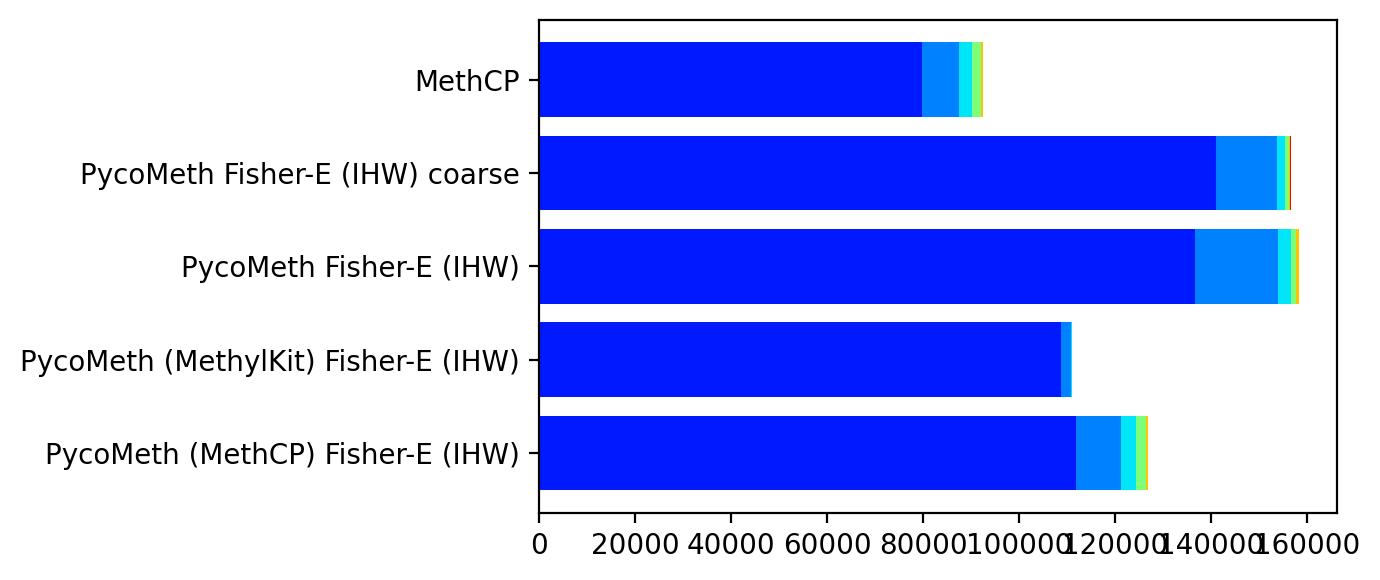

In [33]:
with pa.open_multipage_pdf("hg003_hg004_diffmet_fisher_ihw"):
    tools = ["MethCP", 'PycoMeth Fisher-E (IHW) coarse', 'PycoMeth Fisher-E (IHW)', 'PycoMeth (MethylKit) Fisher-E (IHW)', 'PycoMeth (MethCP) Fisher-E (IHW)'][::-1]
    pa.figure(figsize=(7, 3))
    for i, tool in enumerate(tools):
        plot_bar_diffmetcolored(i, tool)
    plt.yticks(np.arange(0, len(tools), 1), tools)
    pa.saveandshow()

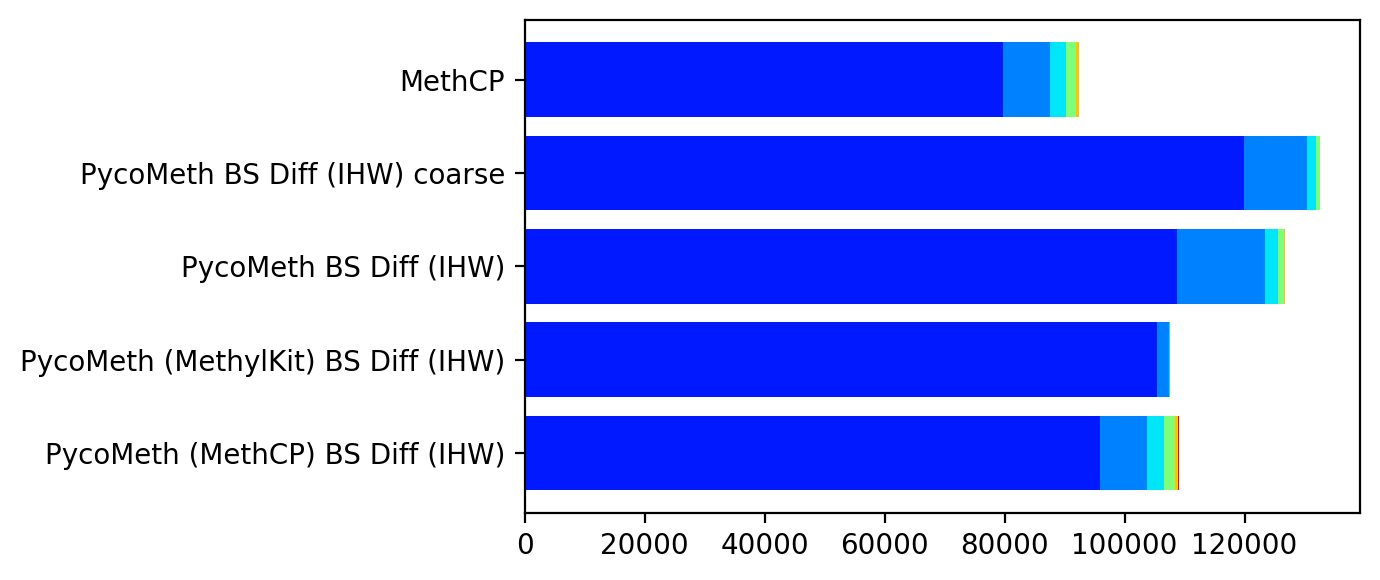

In [40]:
with pa.open_multipage_pdf("hg003_hg004_diffmet_bs_diff_ihw"):
    tools = ["MethCP", 'PycoMeth BS Diff (IHW) coarse', 'PycoMeth BS Diff (IHW)', 'PycoMeth (MethylKit) BS Diff (IHW)', 'PycoMeth (MethCP) BS Diff (IHW)'][::-1]
    pa.figure(figsize=(7, 3))
    for i, tool in enumerate(tools):
        plot_bar_diffmetcolored(i, tool)
    plt.yticks(np.arange(0, len(tools), 1), tools)
    pa.saveandshow()

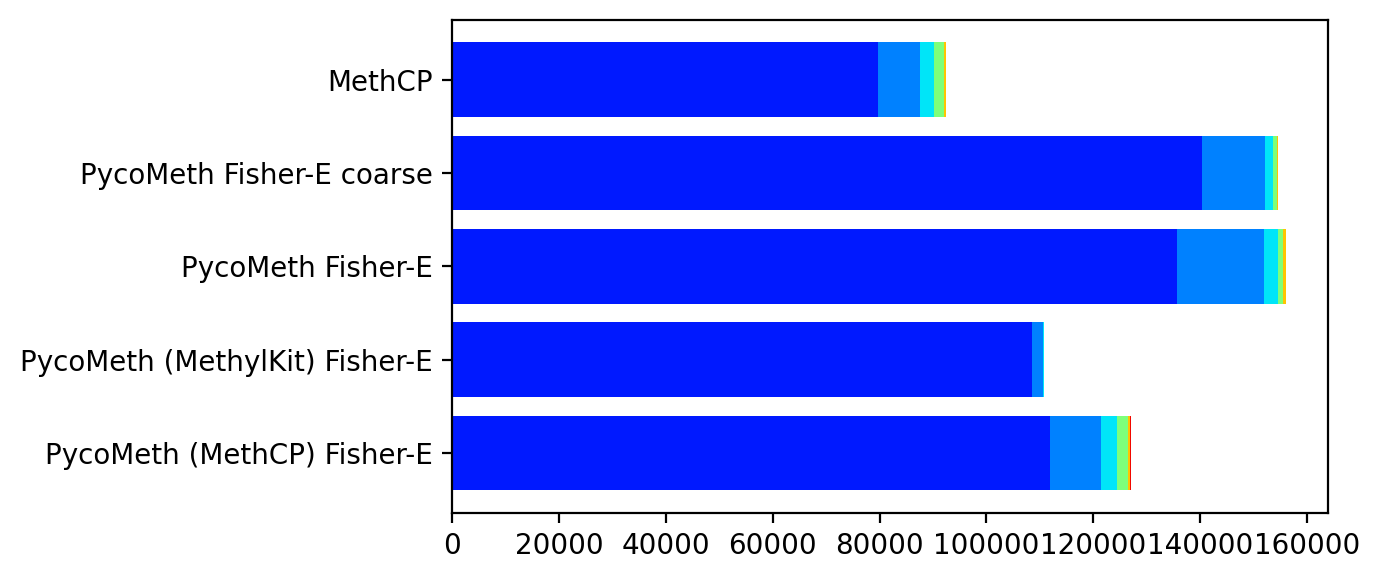

In [39]:
with pa.open_multipage_pdf("hg003_hg004_diffmet_fisher"):
    tools = ["MethCP", 'PycoMeth Fisher-E coarse', 'PycoMeth Fisher-E', 'PycoMeth (MethylKit) Fisher-E', 'PycoMeth (MethCP) Fisher-E'][::-1]
    pa.figure(figsize=(7, 3))
    for i, tool in enumerate(tools):
        plot_bar_diffmetcolored(i, tool)
    plt.yticks(np.arange(0, len(tools), 1), tools)
    pa.saveandshow()

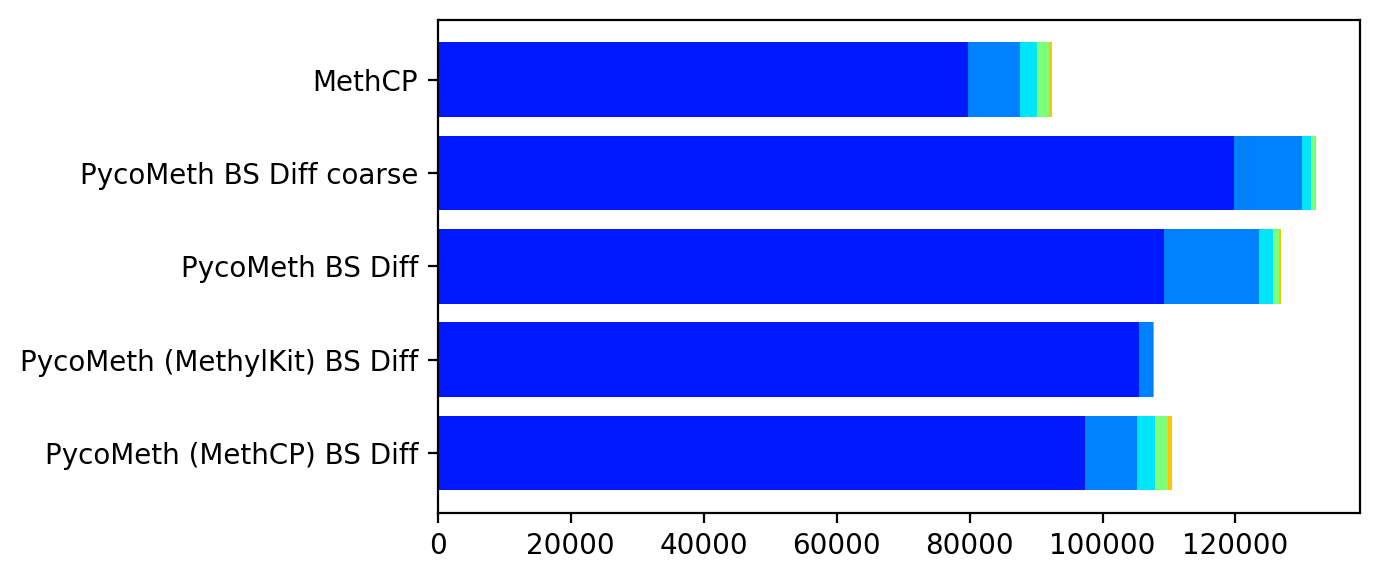

In [41]:
with pa.open_multipage_pdf("hg003_hg004_diffmet_bs_diff"):
    tools = ["MethCP", 'PycoMeth BS Diff coarse', 'PycoMeth BS Diff', 'PycoMeth (MethylKit) BS Diff', 'PycoMeth (MethCP) BS Diff'][::-1]
    pa.figure(figsize=(7, 3))
    for i, tool in enumerate(tools):
        plot_bar_diffmetcolored(i, tool)
    plt.yticks(np.arange(0, len(tools), 1), tools)
    pa.saveandshow()

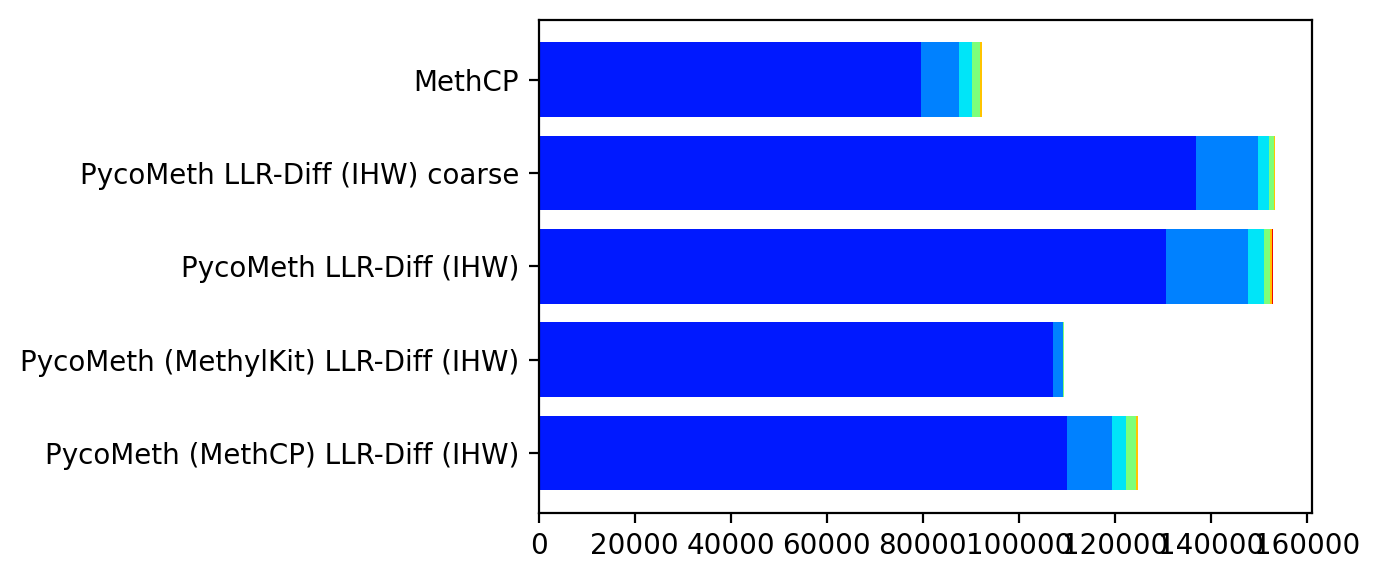

In [42]:
with pa.open_multipage_pdf("hg003_hg004_diffmet_llr_diff_ihw"):
    tools = ["MethCP", 'PycoMeth LLR-Diff (IHW) coarse', 'PycoMeth LLR-Diff (IHW)', 'PycoMeth (MethylKit) LLR-Diff (IHW)', 'PycoMeth (MethCP) LLR-Diff (IHW)'][::-1]
    pa.figure(figsize=(7, 3))
    for i, tool in enumerate(tools):
        plot_bar_diffmetcolored(i, tool)
    plt.yticks(np.arange(0, len(tools), 1), tools)
    pa.saveandshow()

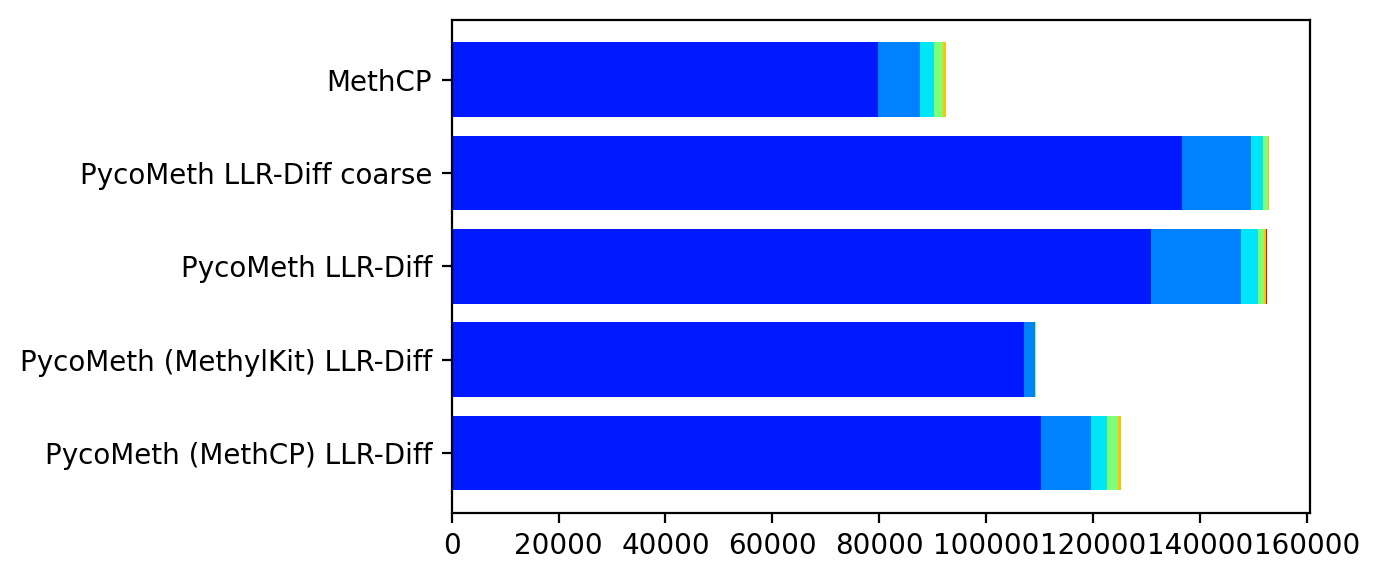

In [43]:
with pa.open_multipage_pdf("hg003_hg004_diffmet_llr_diff"):
    tools = ["MethCP", 'PycoMeth LLR-Diff coarse', 'PycoMeth LLR-Diff', 'PycoMeth (MethylKit) LLR-Diff', 'PycoMeth (MethCP) LLR-Diff'][::-1]
    pa.figure(figsize=(7, 3))
    for i, tool in enumerate(tools):
        plot_bar_diffmetcolored(i, tool)
    plt.yticks(np.arange(0, len(tools), 1), tools)
    pa.saveandshow()

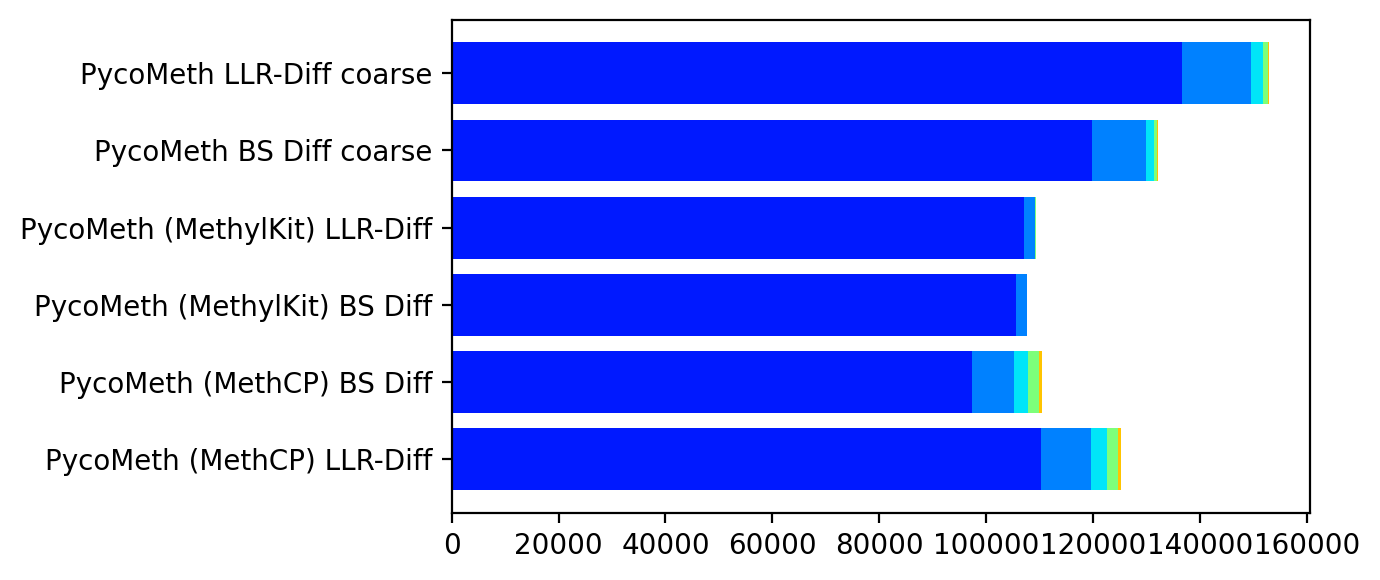

In [44]:
with pa.open_multipage_pdf("hg003_hg004_diffmet_llr_diff_vs_bs_diff"):
    tools = ["PycoMeth LLR-Diff coarse", "PycoMeth BS Diff coarse", "PycoMeth (MethylKit) LLR-Diff", "PycoMeth (MethylKit) BS Diff", "PycoMeth (MethCP) BS Diff", "PycoMeth (MethCP) LLR-Diff"][::-1]
    pa.figure(figsize=(7, 3))
    for i, tool in enumerate(tools):
        plot_bar_diffmetcolored(i, tool)
    plt.yticks(np.arange(0, len(tools), 1), tools)
    pa.saveandshow()


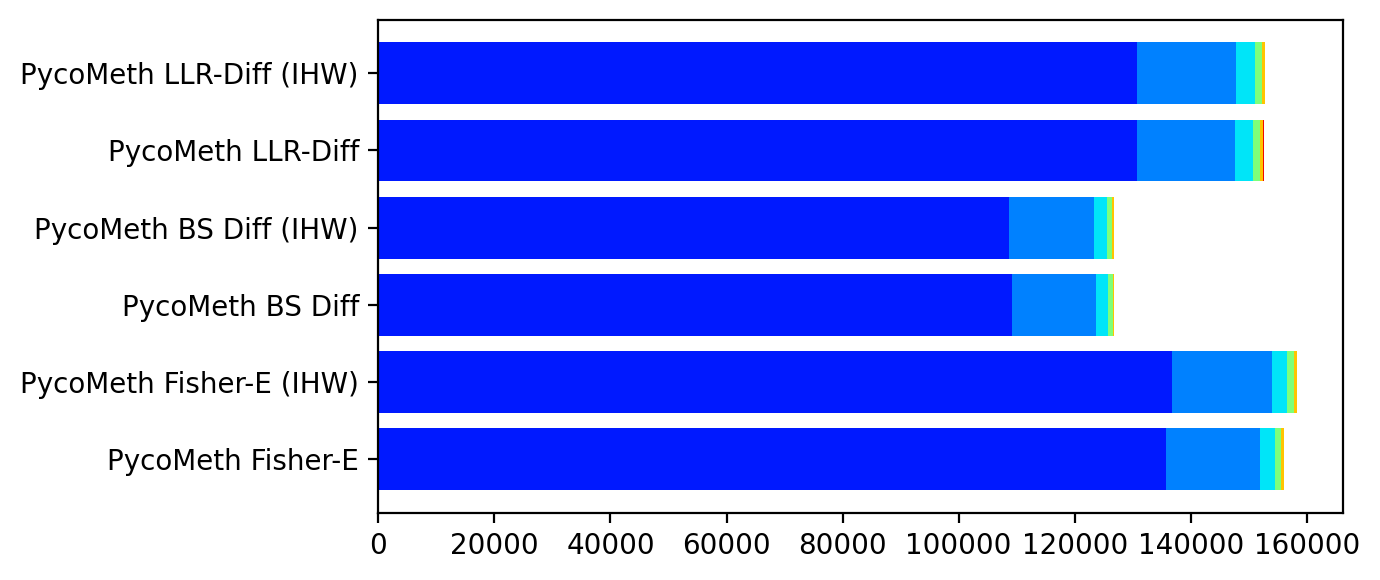

In [45]:
with pa.open_multipage_pdf("hg003_hg004_diffmet_ihw_vs_no_ihw"):
    tools = ["PycoMeth LLR-Diff (IHW)", "PycoMeth LLR-Diff", "PycoMeth BS Diff (IHW)", "PycoMeth BS Diff", "PycoMeth Fisher-E (IHW)", "PycoMeth Fisher-E"][::-1]
    pa.figure(figsize=(7, 3))
    for i, tool in enumerate(tools):
        plot_bar_diffmetcolored(i, tool)
    plt.yticks(np.arange(0, len(tools), 1), tools)
    pa.saveandshow()

